# Sprint 9 - Proyecto

### Descripción del proyecto

Lo has hecho de maravilla en el curso de TripleTen y te han ofrecido hacer prácticas en el departamento de analítica de Showz, una empresa de venta de entradas de eventos. Tu primera tarea es ayudar a optimizar los gastos de marketing. 

# Paso 1. Acceder a los datos y prepararlos para el análisis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Se cargan los datasets
visits = pd.read_csv('/datasets/visits_log_us.csv')
orders = pd.read_csv('/datasets/orders_log_us.csv')
costs = pd.read_csv('/datasets/costs_us.csv')

In [3]:
# Renombrar columnas para consistencia
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
orders.columns = ['buy_ts', 'revenue', 'uid']

In [4]:
# Convertir columnas de fechas a tipo datetime
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

Se añaden columnas auxiliares para facilitar el análisis temporal.
- Por fecha, la columna "session_date", extrae solo la fecha (sin hora) de la columna start_ts.
- Por semana, la columna 'week', si la sesión fue el 18 de junio de 2025, 'week' será 25.
- Por mes, las columnas 'month' y 'order_month' permite agrupar por mes y por mes de compra, respectivamente.

In [5]:
# Se agregaron columnas auxiliares
visits['session_date'] = visits['start_ts'].dt.date
visits['week'] = visits['start_ts'].dt.isocalendar().week
visits['month'] = visits['start_ts'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

Se revisa la información de los dataframes.

In [6]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   device        359400 non-null  object        
 1   end_ts        359400 non-null  datetime64[ns]
 2   source_id     359400 non-null  int64         
 3   start_ts      359400 non-null  datetime64[ns]
 4   uid           359400 non-null  uint64        
 5   session_date  359400 non-null  object        
 6   week          359400 non-null  UInt32        
 7   month         359400 non-null  datetime64[ns]
dtypes: UInt32(1), datetime64[ns](3), int64(1), object(2), uint64(1)
memory usage: 20.9+ MB


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   buy_ts       50415 non-null  datetime64[ns]
 1   revenue      50415 non-null  float64       
 2   uid          50415 non-null  uint64        
 3   order_month  50415 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), uint64(1)
memory usage: 1.5 MB


# Paso 2. Informes y métricas

## Análisis de visitas

In [8]:
visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid', 'session_date',
       'week', 'month'],
      dtype='object')

In [9]:
# 1. Visitas diarias, semanales y mensuales
print('Usuarios únicos por día, semana y mes')
print(visits.groupby('session_date')['uid'].nunique().mean())
print(visits.groupby('week')['uid'].nunique().mean())
print(visits.groupby('month')['uid'].nunique().mean())
 

Usuarios únicos por día, semana y mes
907.9917582417582
5825.288461538462
23228.416666666668


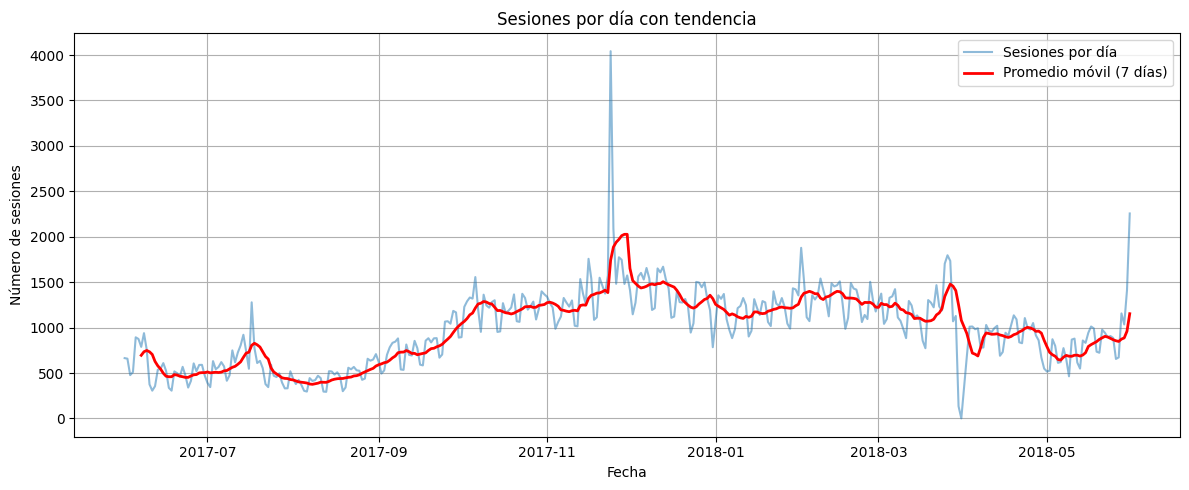

In [10]:
# Número de sesiones por día
sessions_per_day = visits.groupby('session_date')['uid'].count()

# Calcular promedio móvil de 7 días
rolling_avg = sessions_per_day.rolling(window=7).mean()

plt.figure(figsize=(12, 5))
plt.plot(sessions_per_day, label='Sesiones por día', alpha=0.5)
plt.plot(rolling_avg, label='Promedio móvil (7 días)', color='red', linewidth=2)

plt.title('Sesiones por día con tendencia')
plt.xlabel('Fecha')
plt.ylabel('Número de sesiones')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


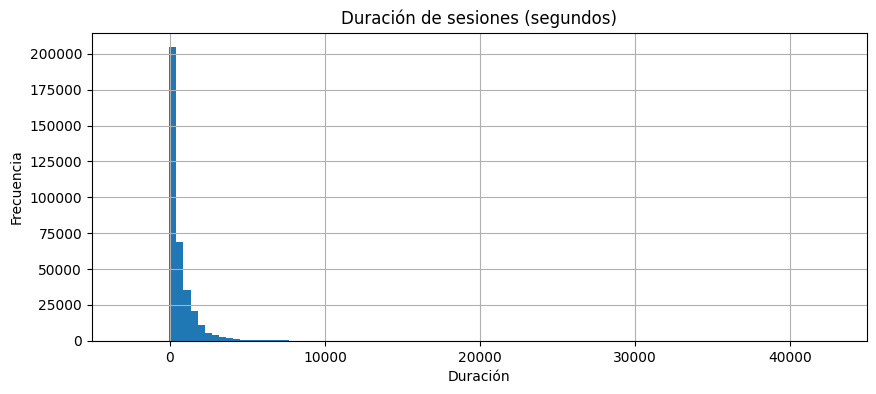

In [11]:
# 3. Duración de cada sesión
visits['session_duration_sec'] = (visits['end_ts']-visits['start_ts']).dt.total_seconds().astype(int)
visits['session_duration_sec'].hist(bins=100, figsize=(10, 4))
plt.title('Duración de sesiones (segundos)')
plt.xlabel('Duración')
plt.ylabel('Frecuencia')
plt.show()


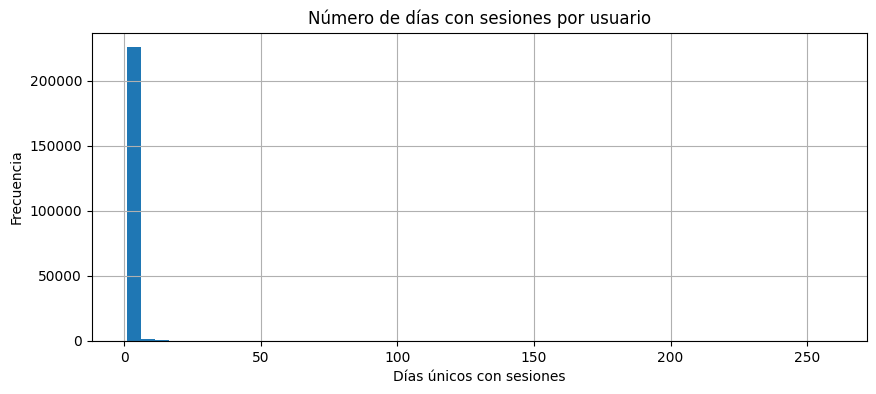

In [12]:
# 4. Frecuencia de regreso de usuarios
#visits['visit_number'] = visits.sort_values(by='start_ts').groupby('uid').cumcount()+1
user_sessions = visits.groupby('uid')['session_date'].nunique()
user_sessions.hist(bins=50, figsize=(10, 4))
plt.title('Número de días con sesiones por usuario')
plt.xlabel('Días únicos con sesiones')
plt.ylabel('Frecuencia')
plt.show()

In [13]:
# Asegurarnos de tener las fechas ordenadas
visits_sorted = visits.sort_values(by='start_ts')

# Obtener el primer y último día de sesión por usuario
user_first_date = visits_sorted.groupby('uid')['session_date'].min()
user_last_date = visits_sorted.groupby('uid')['session_date'].max()

# Unirlo en un DataFrame
retention = pd.DataFrame({
    'first_date': user_first_date,
    'last_date': user_last_date
})

# Crear una columna booleana: True si el usuario volvió en otra fecha
retention['returned'] = retention['first_date'] != retention['last_date']

# Calcular tasa de retención
retention_rate = retention['returned'].mean()

print(f"Tasa de retención (usuarios que regresaron al menos 1 vez): {retention_rate:.2%}")


Tasa de retención (usuarios que regresaron al menos 1 vez): 19.74%


## Análisis de ventas y conversiones

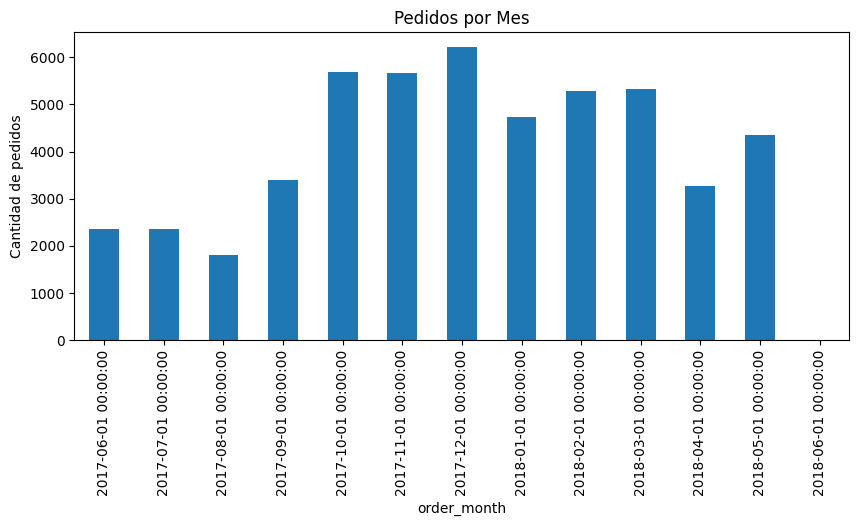

In [14]:
# Usuarios que hicieron su primera compra por cohorte
first_orders = orders.groupby('uid')['buy_ts'].min().reset_index()
first_orders.columns = ['uid', 'first_order_date']
first_orders['cohort'] = first_orders['first_order_date'].astype('datetime64[M]')
orders = orders.merge(first_orders, on = 'uid')

# Conversión en días
orders['conversion_days'] = (orders['buy_ts'] - orders['first_order_date']).dt.days

#pedidos por mes
orders_per_month = orders.groupby('order_month')['uid'].count()
orders_per_month.plot(kind='bar', figsize=(10, 4), title='Pedidos por Mes')
plt.ylabel('Cantidad de pedidos')
plt.show()

In [15]:
# Tamaño promedio de compra
avg_order_value = orders.groupby('uid')['revenue'].sum().mean()
print('Tamaño promedio de compra:', avg_order_value)

Tamaño promedio de compra: 6.901327930345262


## LTV, CAC y ROMI

In [16]:
# Pasos previos
# Cargar datos de visitas desde un archivo CSV
visits = pd.read_csv('/datasets/visits_log_us.csv')
# Convertir las columnas de tiempos de inicio y fin de las visitas al formato de fecha y hora
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'], format="%Y.%m.%d %H:%M:%S")
visits['End Ts'] = pd.to_datetime(visits['End Ts'], format="%Y.%m.%d %H:%M:%S")
# Renombrar las columnas para mayor claridad
visits = visits.rename(columns={"Device": "device", "End Ts": "session_end_ts", 
                                "Source Id": "source_id", "Start Ts": "session_start_ts", "Uid": "uid"})
# Extraer el mes, la semana y la fecha de inicio de sesión
visits['session_month'] = visits['session_start_ts'].astype('datetime64[M]')
visits['session_week'] = visits['session_start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['session_start_ts'].dt.date
# Encontrar la primera visita de cada usuario
first_visits = visits.groupby('uid').agg({'session_start_ts': 'min'}).reset_index()
first_visits.columns = ['uid', 'first_session_start_ts']
# Extraer la fecha y el mes de la primera sesión
first_visits['first_session_dt'] = first_visits['first_session_start_ts'].dt.date
first_visits['first_session_month'] = first_visits['first_session_start_ts'].astype('datetime64[M]')
# Combinar los datos de las primeras visitas con los datos completos de visitas
visits_full = pd.merge(first_visits, visits, on='uid')
# Calcular la diferencia en meses entre la primera visita y las visitas subsiguientes
visits_full['age_months'] = ((visits_full['session_month'] - visits_full['first_session_month']) / 
                             np.timedelta64(1, 'M')).round().astype('int')
# Cargar datos de pedidos desde un archivo CSV
orders = pd.read_csv('/datasets/orders_log_us.csv')
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])
orders = orders.rename(columns={"Buy Ts": "buy_ts", "Revenue": "revenue", "Uid": "uid"})
# Extraer el día y el mes de compra
orders['buy_dt'] = orders['buy_ts'].dt.date
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
# Encontrar la primera compra de cada usuario
first_orders = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_ts']
first_orders['first_order_dt'] = first_orders['first_order_ts'].dt.date
first_orders['first_order_month'] = first_orders['first_order_ts'].astype('datetime64[M]')
# Crear un dataframe con las primeras órdenes y las primeras visitas
buyers = pd.merge(first_visits, first_orders, on='uid')
buyers['first_order_dt'] = pd.to_datetime(buyers['first_order_dt'])
buyers['first_session_dt'] = pd.to_datetime(buyers['first_session_dt'])
# Calcular los días hasta la primera compra
buyers['days_to_first_purchase'] = ((buyers['first_order_ts'] - buyers['first_session_start_ts']) / 
                                    np.timedelta64(1, 'D')).astype('int')


Text(95.72222222222221, 0.5, 'Cohort (First Order Month)')

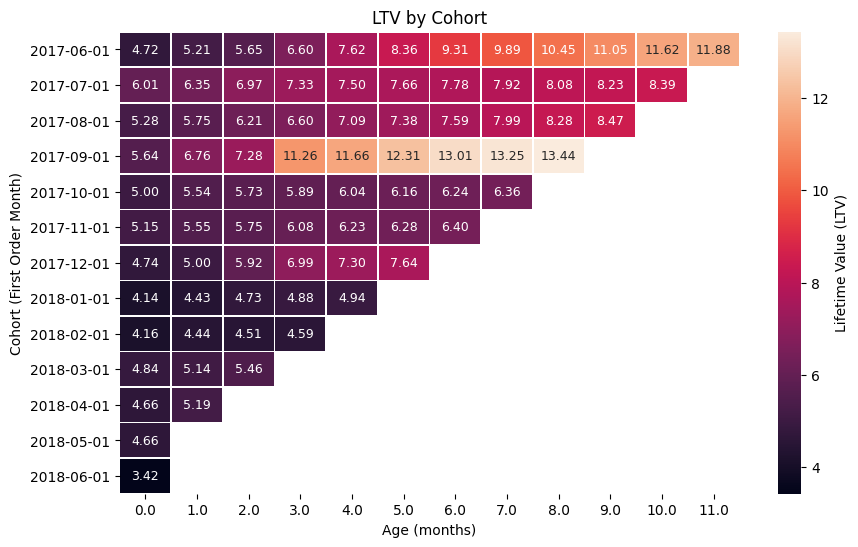

In [17]:
# Cálculo del LTV

# Determinar el tamaño de cada cohorte de compradores
# Agrupa a los compradores por el mes de su primera compra y cuenta los usuarios únicos en cada grupo.
cohort_sizes = buyers.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
# Renombra la columna 'uid' a 'n_buyers' para indicar el número de compradores únicos.
cohort_sizes.rename(columns={'uid': 'n_buyers'}, inplace=True)
# Fusionar las órdenes y compradores, y calcular ingresos por cohorte
# Une los DataFrames 'orders' y 'buyers' usando 'uid' como clave, 
# y agrupa el resultado por mes de la primera orden y mes de orden.
# Calcula la suma de los ingresos para cada grupo.
cohorts = pd.merge(orders, buyers, how='inner', on='uid')\
            .groupby(['first_order_month', 'order_month'])\
            .agg({'revenue': 'sum'}).reset_index()
# Calcular la antigüedad de las cohortes
# Calcula la 'edad' de cada cohorte desde su primera compra, en meses.
cohorts['age_month'] = ((cohorts['order_month'] - cohorts['first_order_month']) / np.timedelta64(1, 'M')).round()
# Actualiza los nombres de las columnas para reflejar los datos que contienen.
cohorts.columns = ['first_order_month', 'order_month', 'revenue', 'age_month']
# Crear el informe de cohortes y calcular el LTV
# Une 'cohort_sizes' con 'cohorts' usando 'first_order_month' como clave.
# Calcula el LTV dividiendo los ingresos por el número de compradores.
cohorts_report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
cohorts_report['ltv'] = cohorts_report['revenue'] / cohorts_report['n_buyers']
# Preparar la tabla pivote para la visualización
# Crea una tabla pivote para visualizar el LTV de cada cohorte por su 'edad' en meses.
cohorts_ltv = cohorts_report.pivot_table(
    index='first_order_month', 
    columns='age_month', 
    values='ltv', 
    aggfunc='sum'
).cumsum(axis=1)
# Redondea los valores a dos decimales y reemplaza los NaN por 0.
cohorts_ltv = cohorts_ltv.round(2)
# Convierte los índices de 'first_order_month' a cadena para mejorar la visualización en el heatmap.
cohorts_ltv.index = cohorts_ltv.index.astype(str)
# Visualización del Heatmap del LTV
# Visualiza el LTV de las cohortes usando un mapa de calor.
plt.figure(figsize=(10, 6))  # Aumenta el tamaño de la figura si es necesario
ax = sns.heatmap(cohorts_ltv, annot=True, fmt=".2f", linewidths=0.5,
                 cbar_kws={'label': 'Lifetime Value (LTV)'}, annot_kws={"size": 9})
plt.title('LTV by Cohort')
plt.xlabel('Age (months)')
plt.ylabel('Cohort (First Order Month)')


In [18]:

 # Calcular el promedio de LTV por edad (mes)
avg_ltv_by_month = (
    cohorts_report
    .groupby('age_month')
    .agg({'ltv': 'mean'})
    .reset_index()
    .sort_values('age_month')
)

# Mostrar el resultado
print("Promedio de LTV por mes de vida de la cohorte:")
print(avg_ltv_by_month)

Promedio de LTV por mes de vida de la cohorte:
    age_month       ltv
0         0.0  4.801682
1         1.0  0.455547
2         2.0  0.405498
3         3.0  0.827223
4         4.0  0.346141
5         5.0  0.333492
6         6.0  0.363777
7         7.0  0.297408
8         8.0  0.297666
9         9.0  0.313637
10       10.0  0.363467
11       11.0  0.256856


CAC medio es: 9.01


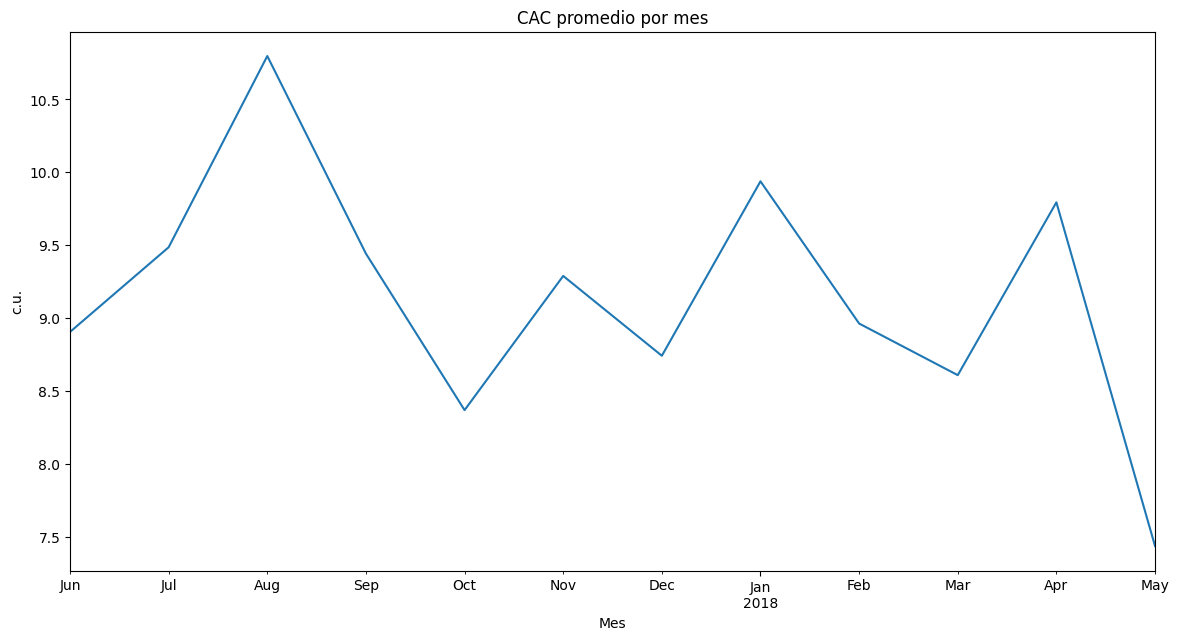

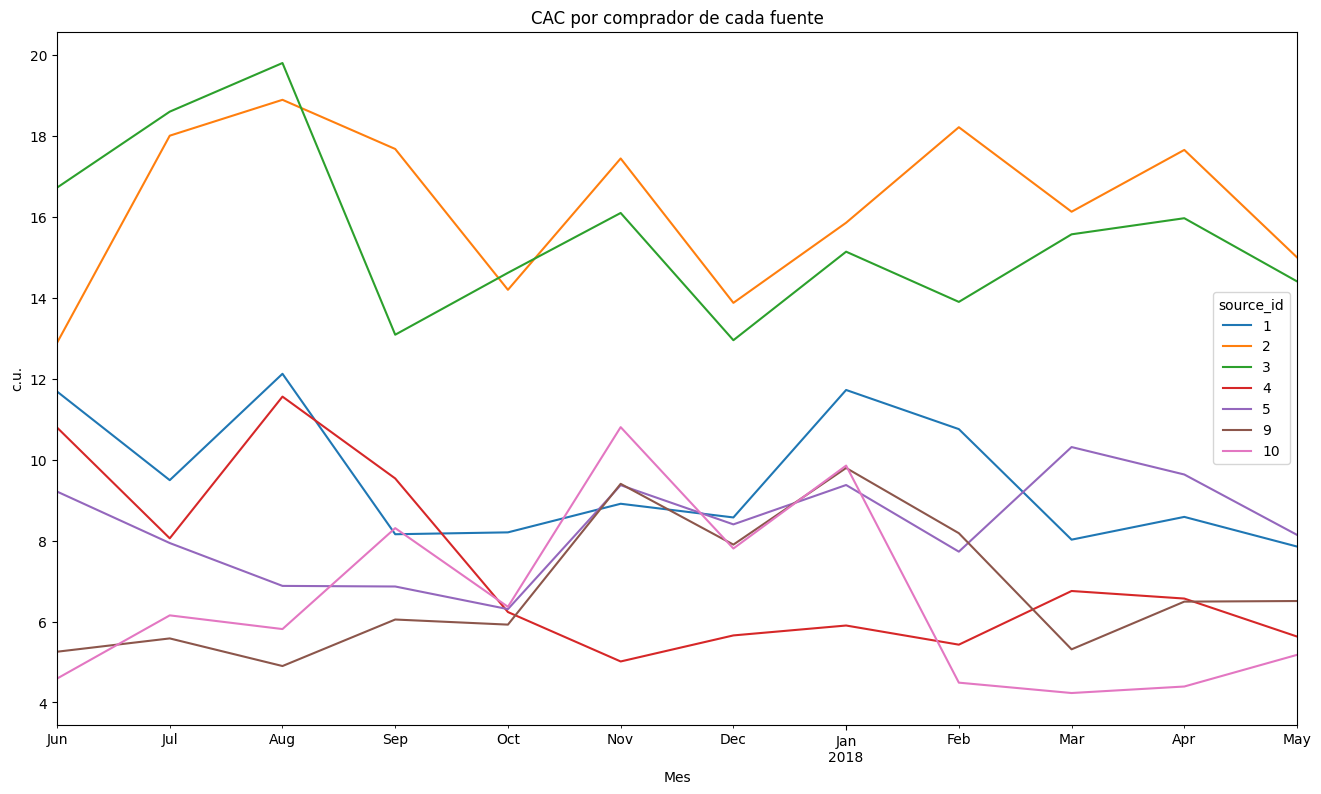

             cac
source_id       
1           9.49
2          16.29
3          15.58
4           7.27
5           8.34
9           6.84
10          6.56


In [19]:
# Cálculo del CAC

# Cargar datos de costos desde un archivo CSV
costs = pd.read_csv('/datasets/costs_us.csv')
costs['dt'] = pd.to_datetime(costs['dt'])
costs['costs_month'] = costs['dt'].astype('datetime64[M]')
# Calcular el CAC medio
print("CAC medio es:", round(costs['costs'].sum() / orders['uid'].nunique(), 2))
# Calcular el CAC por mes
CAC_by_month = pd.merge(costs.groupby('costs_month').agg({'costs': 'sum'}),
                        buyers.groupby('first_order_month').agg({'uid': 'nunique'}),
                        left_index=True, right_index=True)
CAC_by_month['cac'] = CAC_by_month['costs'] / CAC_by_month['uid']
# Gráfico del CAC promedio por mes
CAC_by_month['cac'].plot(figsize=(14, 7), title='CAC promedio por mes', xlabel='Mes', ylabel='c.u.')
# Encontrar la primera fuente por visitante
users = visits_full.sort_values('session_start_ts').groupby('uid').first()
#tome esta tabla prestada para comparar nuestros métodos.
users_ex=visits_full.sort_values('session_start_ts').groupby('uid').first().reset_index()
users = users[['source_id']]

buyers = pd.merge(buyers, users, left_on='uid', right_index=True)
buyers_daily = buyers.groupby(['source_id', 'first_order_dt']).agg({'uid': 'count'}).reset_index()
buyers_daily.rename(columns={'uid': 'n_buyers'}, inplace=True)
buyers_daily['first_order_dt'] = pd.to_datetime(buyers_daily['first_order_dt'])
# Calcular el CAC diario por fuente
costs_ = pd.merge(buyers_daily, costs, left_on=['source_id', 'first_order_dt'], right_on=['source_id', 'dt'])
costs_['cac'] = costs_['costs'] / costs_['n_buyers']
# Gráfico de CAC diario por fuente y mes
costs_.pivot_table(index=['costs_month'], columns='source_id', values='cac', aggfunc='mean').plot(
    figsize=(16, 9), title='CAC por comprador de cada fuente', xlabel='Mes', ylabel='c.u.')
plt.show()
# Calcular el CAC promedio por fuente
cac_by_source = costs_.groupby('source_id').agg({'cac': 'mean'}).round(2)
print(cac_by_source)


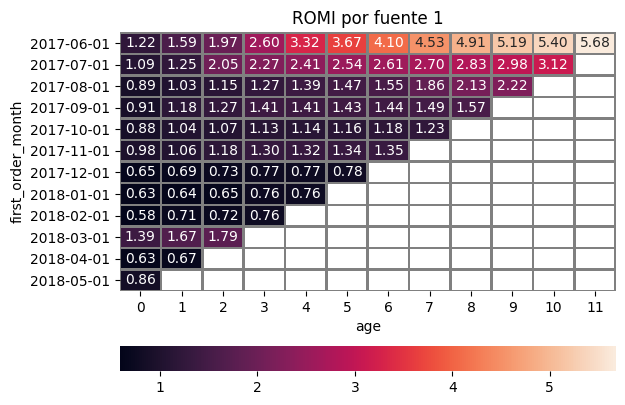

ROMI promedio por edad para la fuente 1:
     source_id  age      romi
0           1    0  0.892768
1           1    1  0.152750
2           1    2  0.172129
3           1    3  0.163976
4           1    4  0.127619
5           1    5  0.088151
6           1    6  0.105599
7           1    7  0.186209
8           1    8  0.215318
9           1    9  0.173470
10          1   10  0.170879
11          1   11  0.281998


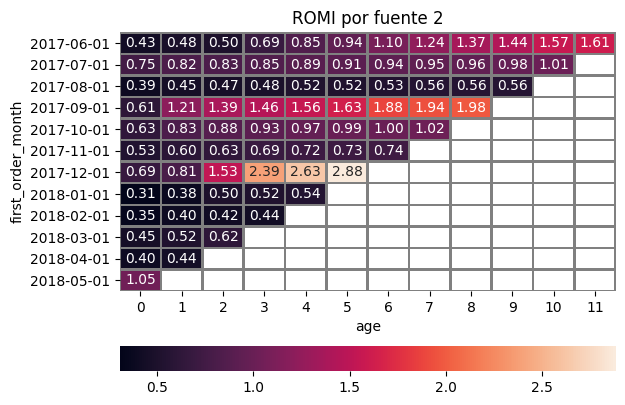

ROMI promedio por edad para la fuente 2:
     source_id  age      romi
0           2    0  0.549286
1           2    1  0.126156
2           2    2  0.128109
3           2    3  0.144599
4           2    4  0.083541
5           2    5  0.066338
6           2    6  0.075785
7           2    7  0.051756
8           2    8  0.045577
9           2    9  0.032394
10          2   10  0.081977
11          2   11  0.041946


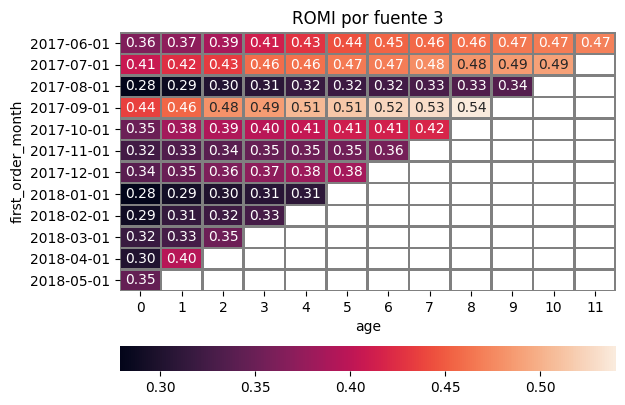

ROMI promedio por edad para la fuente 3:
     source_id  age      romi
0           3    0  0.336151
1           3    1  0.022496
2           3    2  0.013224
3           3    3  0.010893
4           3    4  0.008493
5           3    5  0.006702
6           3    6  0.005036
7           3    7  0.005506
8           3    8  0.005874
9           3    9  0.003480
10          3   10  0.003015
11          3   11  0.002655


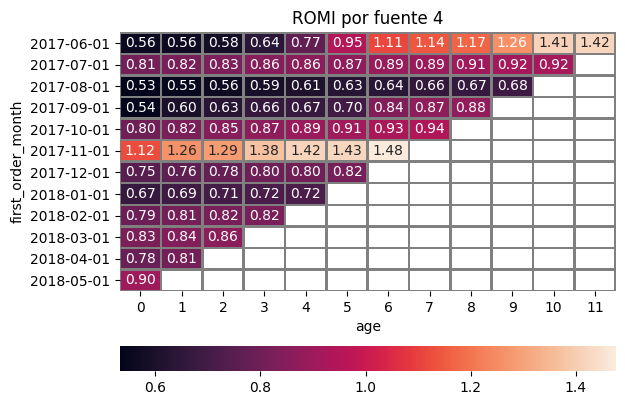

ROMI promedio por edad para la fuente 4:
     source_id  age      romi
0           4    0  0.757409
1           4    1  0.032688
2           4    2  0.018499
3           4    3  0.031013
4           4    4  0.030100
5           4    5  0.039236
6           4    6  0.066406
7           4    7  0.019174
8           4    8  0.013443
9           4    9  0.038728
10          4   10  0.076155
11          4   11  0.009975


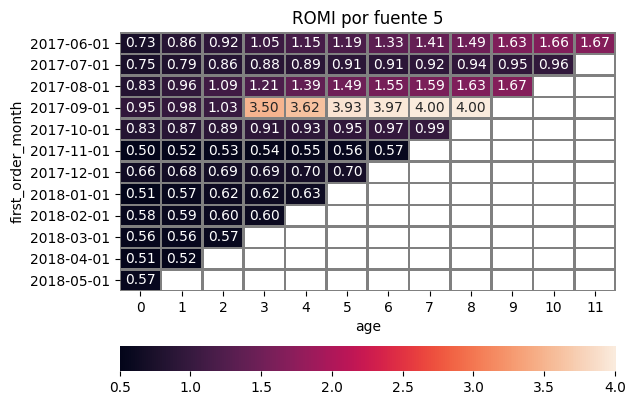

ROMI promedio por edad para la fuente 5:
     source_id  age      romi
0           5    0  0.664923
1           5    1  0.044686
2           5    2  0.041978
3           5    3  0.308790
4           5    4  0.055820
5           5    5  0.069593
6           5    6  0.046401
7           5    7  0.038720
8           5    8  0.034403
9           5    9  0.061817
10          5   10  0.016729
11          5   11  0.017121
ROMI promedio por edad para la fuente 7:
     source_id  age      romi
0           5    0  0.664923
1           5    1  0.044686
2           5    2  0.041978
3           5    3  0.308790
4           5    4  0.055820
5           5    5  0.069593
6           5    6  0.046401
7           5    7  0.038720
8           5    8  0.034403
9           5    9  0.061817
10          5   10  0.016729
11          5   11  0.017121


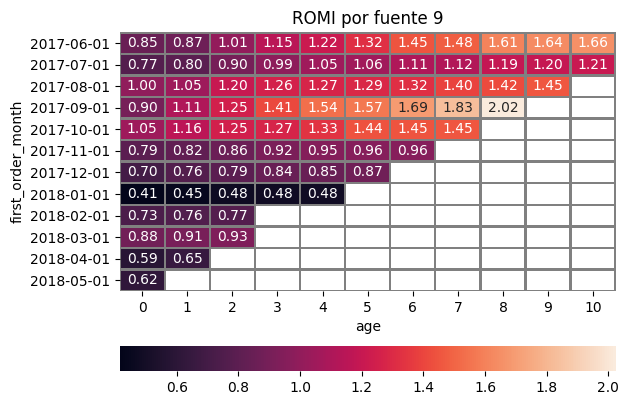

ROMI promedio por edad para la fuente 9:
     source_id  age      romi
0           9    0  0.774013
1           9    1  0.059251
2           9    2  0.076168
3           9    3  0.074036
4           9    4  0.045596
5           9    5  0.043594
6           9    6  0.057699
7           9    7  0.050812
8           9    8  0.103086
9           9    9  0.023394
10          9   10  0.016004


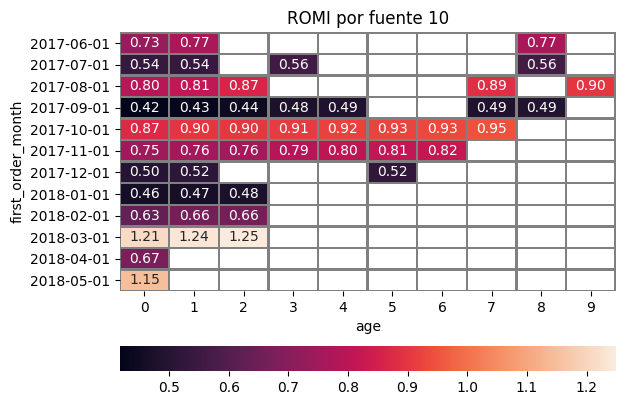

ROMI promedio por edad para la fuente 10:
    source_id  age      romi
0         10    0  0.727377
1         10    1  0.018023
2         10    2  0.013864
3         10    3  0.023614
4         10    4  0.011654
5         10    5  0.006283
6         10    6  0.007746
7         10    7  0.012956
8         10    8  0.002824
9         10    9  0.014447


In [20]:
# Cálculo del ROMI

# Calcular ingresos mensuales por usuario
month_revenue = orders.groupby(['uid', 'order_month']).agg({'revenue': 'sum'}).reset_index()
buyers = buyers.merge(month_revenue, on='uid')
# Iterar a través de cada fuente de tráfico, excepto la fuente número 7
for source, df in buyers.groupby('source_id'):
    if source != 7:
        # Calcular el tamaño de la cohorte para cada fuente y mes de la primera orden
        cohort_sizes_t = (
            df.groupby(['source_id', 'first_order_month'])
            .agg({'uid': 'nunique'})
            .reset_index()
        )
        cohort_sizes_t.columns = ['source_id', 'first_order_month', 'n_buyers']

        # Calcular los ingresos totales por cohorte
        cohorts_revenue_t = (
            df.groupby(['source_id', 'first_order_month', 'order_month'])
            .agg({'revenue': 'sum'})
            .reset_index()
        )
        cohorts_revenue_t.columns = ['source_id', 'first_order_month', 'order_month', 'gp']

        # Fusionar los tamaños de las cohortes con los ingresos por cohortes
        report_romi = pd.merge(cohort_sizes_t, cohorts_revenue_t, on=['source_id', 'first_order_month'])
        report_romi['age'] = (
            report_romi['order_month'] - report_romi['first_order_month']
        ) / np.timedelta64(1, 'M')
        report_romi['age'] = report_romi['age'].round().astype('int')
        report_romi['ltv'] = report_romi['gp'] / report_romi['n_buyers']
        # Calcular costos y CAC para cada cohorte
        report_romi = pd.merge(report_romi, costs.groupby(['source_id', 'costs_month']).agg({'costs': 'sum'}).reset_index(),
                               left_on=['source_id', 'first_order_month'], right_on=['source_id', 'costs_month'])
        report_romi = report_romi.drop(['costs_month'], axis=1)
        report_romi['cac'] = report_romi['costs'] / report_romi['n_buyers']
        report_romi['romi'] = report_romi['ltv'] / report_romi['cac']
        # Crear una tabla pivote de ROMI por edad para cada cohorte
        romi = report_romi\
                .pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')\
                .cumsum(axis=1)
        romi.round(2).fillna('')
        # Configurar el índice como cadena para un mejor formato
        romi.index = romi.index.astype(str)
        # Visualizar el ROMI utilizando un mapa de calor
        sns.heatmap(romi, annot=True, fmt='.2f', linewidths=1, linecolor='grey', cbar_kws={'orientation': 'horizontal'}
                    ).set(title='ROMI por fuente {}'.format(source))
        plt.show()
            # Calcular el ROMI promedio por edad (mes) para esta fuente
    avg_romi_by_month = (
            report_romi
            .groupby(['source_id', 'age'])
            .agg({'romi': 'mean'})
            .reset_index()
        )
    print(f"ROMI promedio por edad para la fuente {source}:\n", avg_romi_by_month)

        #print(report_romi.cumsum(axis=1).mean(axis=0))

 # Paso 3. Conclusión

Después de analizar los datos de visitas, ventas y marketing para Showz, se concluye lo siguiente:

- **Comportamiento de usuarios**: La mayoría de los usuarios regresan en promedio 5 veces y tienen sesiones de duración corta de al menos 16 minutos, hay una buena retención inicial.
- **Conversión**: Muchos usuarios que se convierten dentro de los primeros días y se mantienen constantes en el tiempo sucesivo.
- **Ingresos y LTV**: Al analizar el LTV por cohortes, se observa que los meses de junio y septiembre de 2017 muestran algunos valores altos puntuales. Sin embargo, cuando examinamos el LTV promedio por mes de vida de la cohorte, notamos una clara disminución en el valor generado por usuario a lo largo del tiempo.

El primer mes (age_month = 0) presenta un valor significativamente alto con un LTV promedio de 4.80, atribuible probablemente a la primera cohorte activa. Sin embargo, en los meses posteriores, el LTV promedio cae drásticamente, manteniéndose por debajo de 0.83 y estabilizándose entre 0.25 y 0.45.

Esto sugiere que, aunque algunos cohortes iniciales pudieron generar buenos ingresos de forma puntual, la retención y monetización a largo plazo fueron limitadas. La tendencia decreciente indica que las siguientes cohortes no lograron mantener un valor similar, lo que puede reflejar problemas de fidelización, menor calidad del tráfico o cambios en las estrategias de adquisición.

- **Rentabilidad del marketing**: Al analizar el ROMI por fuente de adquisición, se observa una tendencia común: el mayor rendimiento ocurre en el primer cohorte, seguido de una caída abrupta y una posterior estabilización en niveles bajos.

- Fuente 1: El primer cohorte alcanzó un ROMI de 0.89, pero cayó rápidamente, estabilizándose entre 0.21 y 0.08.

- Fuente 2: El pico fue de 0.54, estabilizándose entre 0.12 y 0.03.

- Fuente 3: Tuvo un rendimiento inicial de 0.33, que descendió a niveles preocupantes, estabilizándose entre 0.01 y 0.002. Esta fuente mostró un ROMI consistentemente bajo.

- Fuente 4: Alcanzó un valor inicial de 0.75, pero la mayoría de los meses posteriores se mantuvo cerca de 0.03, con una aparente caída a 0.009 en el último mes, aunque este valor aislado tiene menor relevancia estadística.

- Fuente 5: Inició con 0.66, descendiendo por debajo de 0.3 y estabilizándose entre 0.06 y 0.01.

- Fuente 9: Mostró un comportamiento similar, iniciando en 0.77, y estabilizándose entre 0.07 y 0.01.

- Fuente 10: Su primer cohorte alcanzó 0.72, pero rápidamente cayó por debajo de 0.02, con valores recurrentes entre 0.01 y 0.002. Además, esta fuente presenta datos faltantes para algunas edades de cohorte, lo que limita su confiabilidad.

En resumen, las fuentes 3 y 10 son las menos rentables, mostrando un ROMI consistentemente bajo y preocupante. Aunque el LTV promedio mensual parecía alto al inicio, esto se explica por el fuerte impacto del primer cohorte de cada fuente. Sin embargo, el rendimiento posterior cae abruptamente, lo que sugiere problemas de fidelización, una disminución en la calidad del tráfico o cambios ineficaces en las estrategias de adquisición.

### Recomendaciones:
- **Optimizar el gasto en fuentes de tráfico** que hayan generado cohortes con alto ROMI y evitar invertir en canales que generaron cohortes con ROMI < 0.01 (fuente 3 y fuente 10).
- **Enfocar esfuerzos en repetir las estrategias de adquisición** usadas en los meses de mayor éxito (junio, septiembre) y analizar por qué esas campañas funcionaron mejor (fuentes, dispositivos, creatividad, targeting, etc.)
- **El LTV tiende a estabilizarse en valores bajos** por lo que si una cohorte tiene un primer mes alto, será lo máximo que alcancazá a estar y probablemente no lo será posteriormente. Así que un primer paso flojo muy seguramente garantizará una estabilización en valores bajos.
 
 